# Polygon operations

Polygons are essential to the tools developed in teqpflsh. The [GEOS](https://libgeos.org/) C++ library is used for all the polygon operations. Profiling is provided in this file to indicate the computational speed of operations with this library.

One of the key operations in ``teqpflsh`` is to take an arbitrary polygon and sample it evenly. This is for instance how the single-phase points are distributed within the single-phase polygon(s). For efficiency, this process is done by first breaking up the non-intersecting polygon into a number of triangles. The reason for that process is that sampling a triangle evenly is easy, and you weight the samples of the triangles by their area to get the evenly sampled polygon. This generates samples within the polygon. To get there, first examples are shown of operations on polygons powered by the tools in ``teqpflsh`` followed by the even sampling.

In [1]:
import numpy as np
import teqpflsh
import matplotlib.pyplot as plt
import timeit

def getcircle(r, N, *, ptr):
    t = np.linspace(0, 2*np.pi, 10000)
    X,Y = np.cos(t), np.sin(t)
    return ptr.makeclosedpolygon(X,Y)

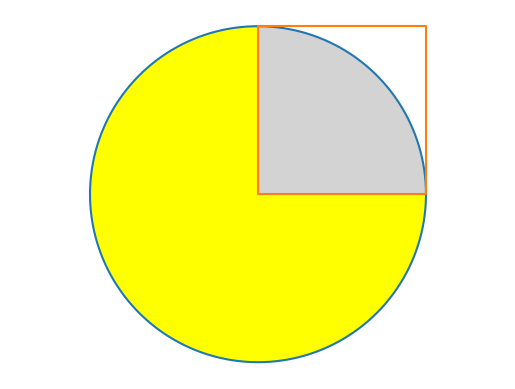

In [2]:
# Here we do intersection and difference operations on simple 
# polygons to demonstrate how polygon operations work
# in teqpflsh

ptr = teqpflsh.GeometryFactoryHolder()

# Polygon for a circle
t = np.linspace(0, 2*np.pi, 10000)
X,Y = np.cos(t), np.sin(t)
poly1 = ptr.makeclosedpolygon(X, Y)
plt.plot(X, Y)

# Polygon for a square
x = np.array([0,1,1,0,0])
y = np.array([0,0,1,1,0])
poly2 = ptr.makeclosedpolygon(x, y)
plt.plot(x, y)

# Intersection of the circle and the square
Xi, Yi = poly1.intersection(poly2).getXY()
plt.fill(Xi, Yi, 'lightgrey')

# Difference of the circle and the square
Xd, Yd = poly1.difference(poly2).getXY()
plt.fill(Xd, Yd, 'yellow')

plt.axis('equal')
plt.axis('off');

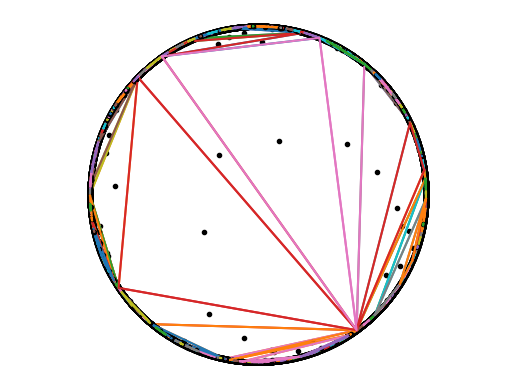

In [3]:
ptr = teqpflsh.GeometryFactoryHolder()

# Polygon for a circle
poly1 = getcircle(1, 10000, ptr=ptr)
plt.plot(*poly1.getXY())

# Delaunay triangulation of the circle into triangles that fully cover the original polygon
tri = poly1.DelaunayTriangulate()
Ngeo = tri.getNumGeometries()
for i in range(Ngeo):
    geo = tri.getGeometryN(i)
    X, Y = geo.getXY()
    cen = geo.getCentroid()
    x, y = cen.getX(), cen.getY()
    plt.plot(x, y, 'k.')
    plt.plot(X, Y)
del ptr
plt.axis('equal')
plt.axis('off');

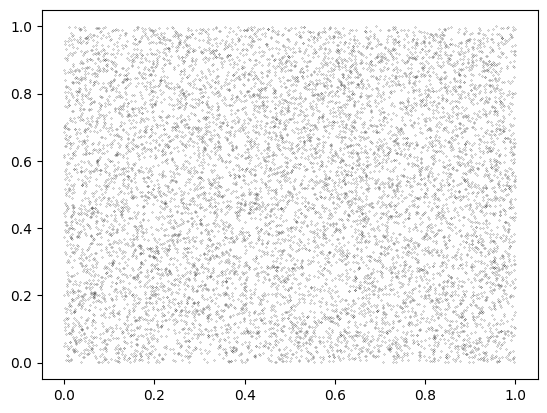

In [4]:
# A box, randomly sampled using the code in 
# teqpflsh
X = np.array([0,1,1,0,0.0])
Y = np.array([0,0,1,1,0.0])
N = 10000
reg = teqpflsh.QuadRegion2D(x=X,y=Y)
x, y = np.zeros(N,), np.zeros(N)
reg.sample_random(len(x), x, y)
plt.plot(x, y, 'k.', ms=0.3);
del reg

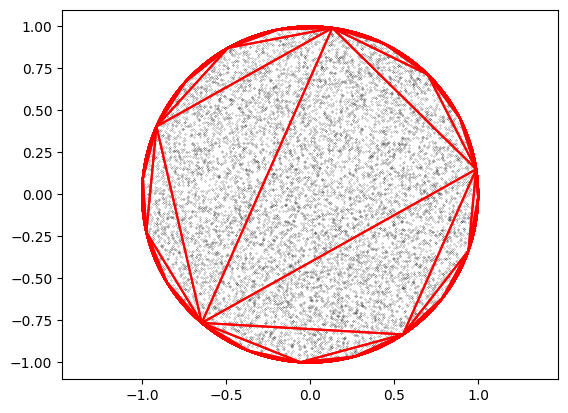

In [5]:
# A circle, randomly sampled by first triangulation and then sampling
ptr = teqpflsh.GeometryFactoryHolder()
circ = getcircle(1, 10000, ptr=ptr)
X, Y = circ.getXY()

# The "region", which here is a circle
reg = teqpflsh.QuadRegion2D(x=X,y=Y)
x, y = np.zeros(N,), np.zeros(N) # allocate buffers
reg.sample_random(len(x), x, y)
plt.plot(x, y, 'k.', ms=0.3)
plt.axis('equal')

# And here are the triangles
tri = reg.do_fast_triangulation()
for i in range(tri.getNumGeometries()):
    coords = tri.getGeometryN(i).getCoordinates()
    # get the vertices of the triangle
    Ncoords = coords.getSize()
    x = [coords.getX(_) for _ in range(Ncoords)]
    y = [coords.getY(_) for _ in range(Ncoords)]
    plt.plot(x, y, 'r')
del reg

1 343.95409747958183
2 33.52916974108666
3 3.48491600016132
4 0.47287080087698996
5 0.1693791605066508


6 0.14071825001155958


7 0.13905381249496712


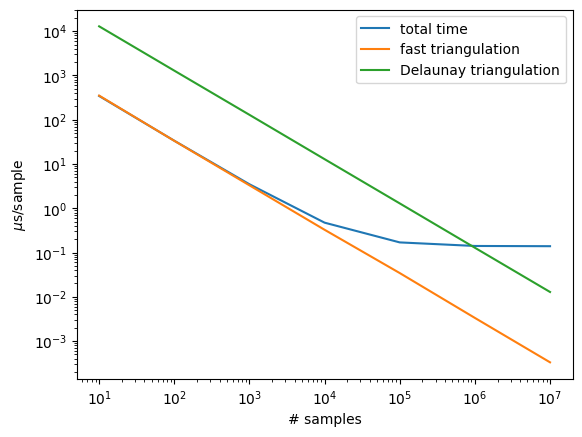

In [6]:
# For few samples, you are dominated by triangulation cost
# and then for more samples, the cost is dominated by the sampling
# itself. The more refined the polygon, the slower the triangulation

reg = teqpflsh.QuadRegion2D(x=X,y=Y)
Deltimes, tritimes, exponents, times = [],[],[],[]
for exponent in range(1, 8):
    N = 10**exponent    
    x, y = np.zeros(N,), np.zeros(N)
    
    tic = timeit.default_timer()
    reg.do_fast_triangulation()
    toc = timeit.default_timer()
    tritimes.append((toc-tic)*1e6/N)

    tic = timeit.default_timer()
    reg.do_Delaunay_triangulation()
    toc = timeit.default_timer()
    Deltimes.append((toc-tic)*1e6/N)
    
    tic = timeit.default_timer()
    reg.sample_random(len(x), x, y)
    toc = timeit.default_timer()
    times.append((toc-tic)*1e6/N)
    print(exponent, times[-1])
    exponents.append(exponent)

plt.plot(10**np.array(exponents), times, label='total time')
plt.plot(10**np.array(exponents), tritimes, label='fast triangulation')
plt.plot(10**np.array(exponents), Deltimes, label='Delaunay triangulation')
plt.xscale('log')
plt.yscale('log')
plt.gca().set(xlabel=r'# samples', ylabel=r'$\mu$s/sample')
plt.legend()
plt.show()
del reg